In [1]:
import pandas as pd

train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test=test.drop("Comb",axis=1)

gender_dict = {'F':0, 'M':1}
train['Gender']=train.Gender.apply(lambda x:gender_dict[x])
test['Gender']=test.Gender.apply(lambda x:gender_dict[x])


In [2]:
print(train.shape)
print(test.shape)

(550068, 12)
(233599, 11)


In [3]:
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
train['Age']=train.Age.apply(lambda x:age_dict[x])

test['Age']=test.Age.apply(lambda x:age_dict[x])

In [4]:
city_dict = {'A':0, 'B':1, 'C':2}

train['City_Category']=train.City_Category.apply(lambda x:city_dict[x])
test['City_Category']=test.City_Category.apply(lambda x:city_dict[x])


In [5]:
stay_dict = {'0':0, '1':1, '2':2,'3':3,'4+':4}
train.Stay_In_Current_City_Years=train.Stay_In_Current_City_Years.apply(lambda x:stay_dict[x])
test.Stay_In_Current_City_Years=test.Stay_In_Current_City_Years.apply(lambda x:stay_dict[x])

In [6]:
# feature representing the count of each user
user_count=train.groupby('User_ID',as_index=False).Product_ID.count()
user_count.columns=['User_ID','User_Count']
train=train.merge(user_count,on="User_ID")
test=test.merge(user_count,on="User_ID")

In [7]:
print(train.shape)
print(test.shape)

(550068, 13)
(233599, 12)


In [8]:
product_count=train.groupby('Product_ID',as_index=False).User_ID.count()
product_count.columns=['Product_ID','Product_Count']
train=train.merge(product_count,on='Product_ID')
test=test.merge(product_count,on='Product_ID',how="left")



In [9]:
print(train.shape)
print(test.shape)

(550068, 14)
(233599, 13)


In [10]:
product_mean=train.groupby('Product_ID',as_index=False).Purchase.mean()
product_mean.columns=['Product_ID','Product_Mean']
train=train.merge(product_mean,on='Product_ID',how='left')
test=test.merge(product_mean,on='Product_ID',how="left")
test.loc[pd.isnull(test.Product_Mean),'Product_Mean']=train.Purchase.mean()

In [11]:
train['flag_high']=0
train.loc[train.Purchase>train.Product_Mean,'flag_high']=1

In [12]:
user_high=train.groupby('User_ID',as_index=False).flag_high.mean()
user_high.columns=['User_ID','flag_high_mean']

In [13]:
train=train.merge(user_high,on="User_ID",how="left")
test=test.merge(user_high,on="User_ID",how="left")


In [14]:
y=train.Purchase

In [15]:
train.columns

Index([u'User_ID', u'Product_ID', u'Gender', u'Age', u'Occupation',
       u'City_Category', u'Stay_In_Current_City_Years', u'Marital_Status',
       u'Product_Category_1', u'Product_Category_2', u'Product_Category_3',
       u'Purchase', u'User_Count', u'Product_Count', u'Product_Mean',
       u'flag_high', u'flag_high_mean'],
      dtype='object')

In [16]:
remove_cols=['Purchase','Product_ID','flag_high']
preds=[i for i in train.columns if i not in remove_cols]

In [17]:
X_train=train[preds]
X_test=test[preds]

In [18]:
target=train.Purchase
import sys
sys.path.append("/home/ubuntu/xgboost/python-package/xgboost")
import xgboost as xgb
import numpy as np
%matplotlib inline

In [19]:
import xgboost as xgb
%matplotlib inline

In [20]:
from sklearn.metrics import r2_score
def modelfit(target,alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, 
                              label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics=['rmse'], 
                          early_stopping_rounds=early_stopping_rounds 
                         # show_progress=False
                          )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    print("fit")
    #Fit the algorithm on the data
    model=alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
    print("predict")
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print "\nModel Report"
    print "r2 (Train): %f" % r2_score(dtrain[target], dtrain_predictions)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    return model

In [21]:
predictors = [x for x in train.columns if x not in ['flag_high','Product_ID','Purchase']]
from sklearn import preprocessing

for f in predictors:
    if X_train[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(X_train[f].values)+list(X_test[f].values)))
        X_train[f]   = lbl.transform(list(X_train[f].values))
        X_test[f]   = lbl.transform(list(X_test[f].values))
        

In [22]:
target.values

array([ 8370, 13591, 11022, ...,  2277,  1866,  7062])

fit
predict

Model Report
r2 (Train): 0.834829


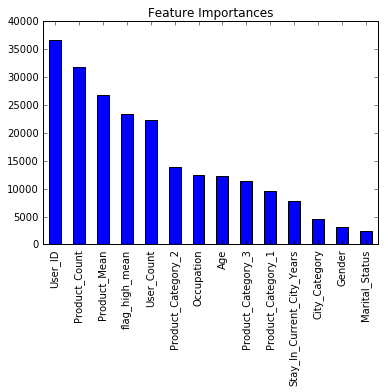

In [23]:

xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 #subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=-1,
 #scale_pos_weight=1,
 seed=27)
alg=modelfit('Purchase',xgb2, train, predictors)

In [28]:


from sklearn.grid_search import GridSearchCV
param_test1 = {
 'max_depth':(6,8,10,12) ,
 'min_child_weight':(1,2,3,4,5)
}

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score
gsearch1 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test1, 
                       #scoring='r2',
                        #n_jobs=5,
                        verbose=1,
                        #iid=False,
                        cv=5)

gsearch1.fit(train[predictors].values,target.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 14.4min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 40.0min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


([mean: 0.74719, std: 0.01476, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.74711, std: 0.01473, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.74718, std: 0.01477, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.74719, std: 0.01475, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.74710, std: 0.01472, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.74760, std: 0.01492, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.74770, std: 0.01499, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.74759, std: 0.01492, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.74765, std: 0.01487, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.74763, std: 0.01474, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.74645, std: 0.01524, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.74641, std: 0.01524, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: 0.74651, std: 0.01528, params:

In [29]:
xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=2,
 gamma=0,
 #subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=-1,
 #scale_pos_weight=1,
 seed=27)
alg=modelfit('Purchase',xgb2, train, predictors)

KeyboardInterrupt: 

In [28]:
param_test2 = {
'gamma':[0.1,0.2,0.3]
}

xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=2,
 gamma=0,
 #subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=-1,
 #scale_pos_weight=1,
 seed=27)

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score
gsearch1 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test2, 
                       #scoring='r2',
                        #n_jobs=5,
                        verbose=2,
                        #iid=False,
                        cv=5)

gsearch1.fit(train[predictors].values,target.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 - 3.2min
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 - 3.2min
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 - 3.2min
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 - 3.2min
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 - 3.2min
[CV] gamma=0.2 .......................................................
[CV] .............................................. gamma=0.2 - 3.2min
[CV] gamma=0.2 .......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 48.2min finished


([mean: 0.74412, std: 0.01565, params: {'gamma': 0.1},
  mean: 0.74412, std: 0.01565, params: {'gamma': 0.2},
  mean: 0.74412, std: 0.01565, params: {'gamma': 0.3}],
 {'gamma': 0.1},
 0.74412133307682915)

fit
predict

Model Report
r2 (Train): 0.804637


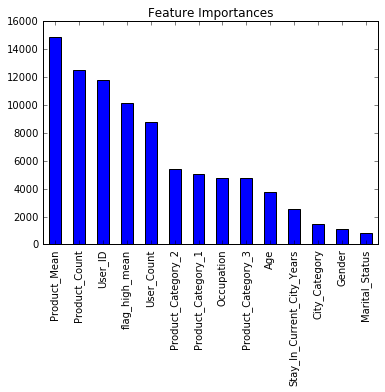

In [23]:
xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=2,
 gamma=0.1,
 #subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=-1,
 #scale_pos_weight=1,
 seed=27)
alg=modelfit('Purchase',xgb2, train, predictors)


In [24]:
pred_test_y = alg.predict(test[predictors])


In [25]:
pred_test_y[pred_test_y<0] = 1
test_user_id=test.User_ID
test_product_id=test.Product_ID

In [26]:
out_df = pd.DataFrame({"User_ID":test_user_id})
out_df["Product_ID"] = test_product_id
out_df["Purchase"] = pred_test_y
out_df.to_csv("sub4.csv", index=False)

In [26]:
print("yo")

yo
